<a href="https://colab.research.google.com/github/jouherdauf/Rossman-Sales-Prediction-Regression/blob/main/Rossmonn_Retail_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams.update({'figure.figsize':(8,5),'figure.dpi':100})
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [187]:
# Load Dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Reading**


In [188]:
# creating dataframes and store csv data
sales =pd.read_csv('/content/drive/My Drive/Rossmann-Sales-Prediction/Rossmann Stores Data.csv')
stores =pd.read_csv('/content/drive/My Drive/Rossmann-Sales-Prediction/store.csv')

# **Data Inspection**


Two datasets are given: store data and sales data. These two datasets should be merged after data cleaning and 'Sales' will be taken as the target feature.

In [189]:
# exploring the head of the sales dataframe
sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [190]:
# exploring the head of the store dataframe
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [191]:
# Dataset Rows & Columns count of sales
print(f'sales - Rows:{len(sales.axes[0])},Columns:{len(sales.axes[1])}')

sales - Rows:1017209,Columns:9


In [192]:
# Dataset Rows & Columns count of stores
print(f'stores - Rows:{len(stores.axes[0])},Columns:{len(stores.axes[1])}')

stores - Rows:1115,Columns:10


In [193]:
 sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [194]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


# **Data Cleaning**

### **Checking for duplicates values**

In [195]:
# Dataset Duplicate Value Count
stores[stores.duplicated()].shape # checking the  number of duplicate rows

(0, 10)

### **Checking for null values**

In [196]:
# Missing Values/Null Values Count
stores.isnull().sum().sort_values(ascending = False)

Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
CompetitionDistance            3
Store                          0
StoreType                      0
Assortment                     0
Promo2                         0
dtype: int64

 Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceMonth,CompetitionOpenSinceYear have very high number of null values so we will remove these features.CompetitionDistance have just 3 null values.

In [197]:
# Visualizing the missing values
# remove features
stores = stores.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2SinceWeek',
                     'Promo2SinceYear', 'PromoInterval'], axis=1)

CompetitionDistance is the distance in meters to the nearest competitor store.Let's first have a look at its distribution

Text(0.5, 1.0, 'Distributin of Store Competition Distance')

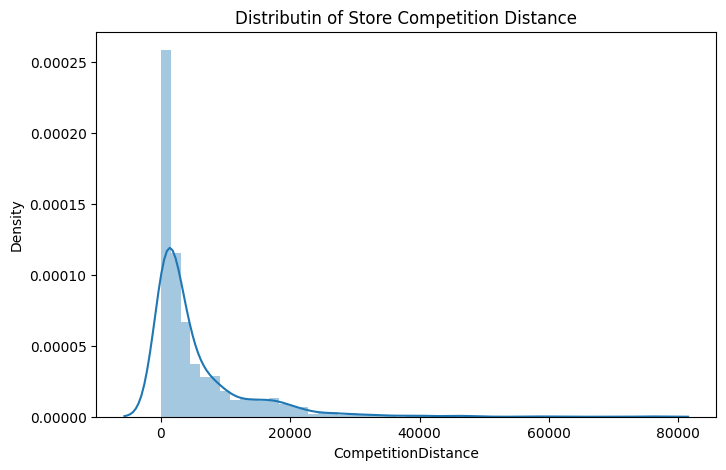

In [198]:
sns.distplot(stores.CompetitionDistance.dropna())
plt.title("Distributin of Store Competition Distance")

Distribution of Competition Distance is positively skewed,so we will replace missing values with median.

In [199]:
# replace missing values in CompetitionDistance with median for the store dataset
stores.CompetitionDistance.fillna(stores.CompetitionDistance.median(), inplace=True)

In [200]:
sales.isnull().sum().sort_values(ascending = False)

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [201]:
#Merging the dataset
df = pd.merge(stores, sales, on='Store', how='inner')

## **Data Description**

* **Id** - an Id that represents a (Store, Date) duple within the set
*  **Store** - a unique Id for each store(Integer)
*  **Sales** - the turnover for any given day (Dependent Variable)
* **Customers** - the number of customers on a given day
* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType** - differentiates between 4 different store models: a, b, c, d
* **Assortment** - describes an assortment level: a = basic, b = extra, c = extended. An assortment strategy in retailing involves the number and type of products that stores display for purchase by consumers.
* **CompetitionDistance** - distance in meters to the nearest competitor store
* **CompetitionOpenSince**[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* **Promo** - indicates whether a store is running a promo on that day
* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since**[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [202]:
#remove rows when store is closed ie 0 value
df.drop(df[df['Open'] == 0].index,inplace = True)
df.drop('Open',axis =1, inplace =True)

In [203]:
# Check Unique Values for each variable.
lengths = sorted([len(s) for s in sorted(df)])
space = lengths[-1]*' '
for i in sorted(df):
  if df[i].nunique() <= 12:
    print(f'{i} {space[len(i):20]}{df[i].nunique()} {df[i].unique()}')

Assortment          3 ['a' 'c' 'b']
DayOfWeek           7 [5 4 3 2 1 6 7]
Promo               2 [1 0]
Promo2              2 [0 1]
SchoolHoliday       2 [1 0]
StateHoliday        5 ['0' 0 'a' 'b' 'c']
StoreType           4 ['c' 'a' 'd' 'b']


In [204]:
#converting StateHoliday 0 values into string.
df.loc[df['StateHoliday'] == 0,'StateHoliday'] = '0'
df = df.astype({'StateHoliday':'string'})

In [205]:
#checking percentage category of State Holiday of type a,b,c.
(df.loc[(df['StateHoliday'] == 'a')|(df['StateHoliday'] == 'b') | (df['StateHoliday'] == 'c'),'StateHoliday'].count()/df['StateHoliday'].count())*100

0.10776985096969181

In [206]:
df.drop('StateHoliday',axis = 1,inplace =True)


State holidays categorized as a, b, and c account for a mere 0.1% of all state-related entries. Hence, we have decided to eliminate state holidays from consideration.

In [207]:
# extract year, month, day  of year from "Date"
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype("int64")



In [208]:
df.drop('Date',axis =1,inplace=True)


# **Data Wrangling**

In [209]:
stores = df.groupby(['Store'],as_index =False)['Sales'].mean()

<Axes: xlabel='Store', ylabel='Sales'>

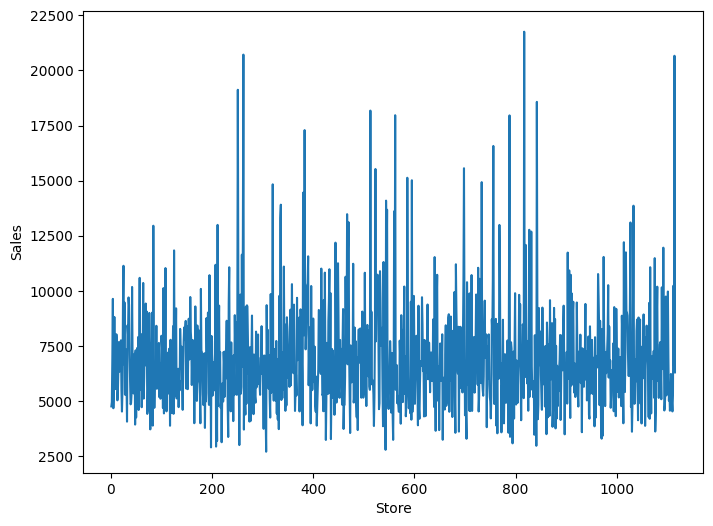

In [210]:
plt.figure(figsize = (8,6))
sns.lineplot(x="Store", y="Sales",data= stores,errorbar = None)

The line plot suggests that there is no significant influence on sales as the number of stores increases, with most stores having average sales ranging from 5000 to 10000, aside from a few outliers. Consequently, store number is not a crucial factor in sales analysis.So,we will drop the Store Column.

In [211]:
df.drop('Store',axis=1,inplace = True)

Lets check  School Holiday increase the sales or not.

<Axes: xlabel='SchoolHoliday', ylabel='Sales'>

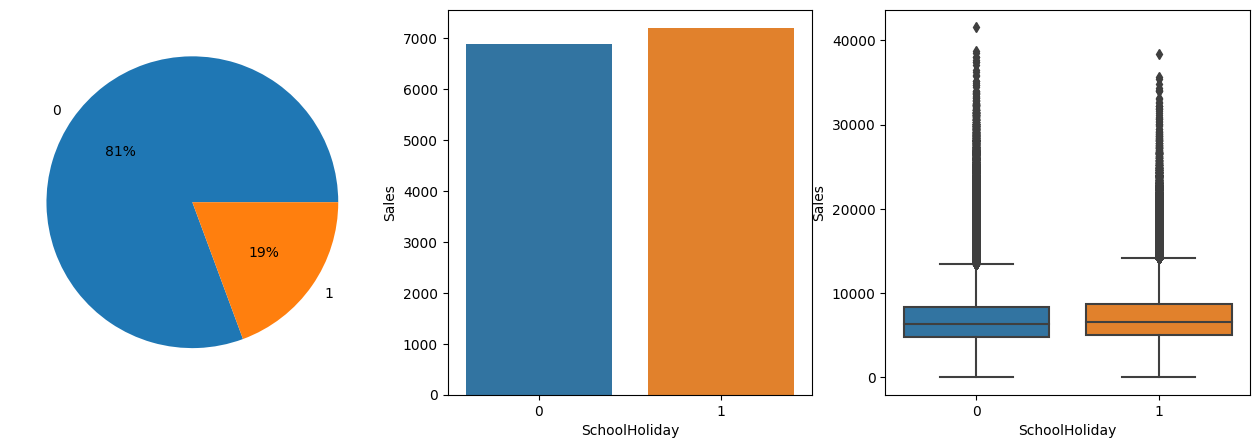

In [212]:
ab = df.groupby(['SchoolHoliday'],as_index =False)['Sales'].count()
fig, axes = plt.subplots(1,3, figsize=(16,5))
axes[0].pie(ab['Sales'],labels=ab['SchoolHoliday'],autopct = '%.0f%%')
sns.barplot(ax =axes[1] ,x="SchoolHoliday", y="Sales",data= df,errorbar = None)
sns.boxplot(ax =axes[2] ,x = 'SchoolHoliday', y = 'Sales', data = df)

Despite school holidays comprising only 19% of the total data points, the average sales during school holidays surpass those during non-school holidays.

In [213]:
Categorical_feature = df.describe(include=['object','category']).columns

<Axes: xlabel='StoreType', ylabel='Sales'>

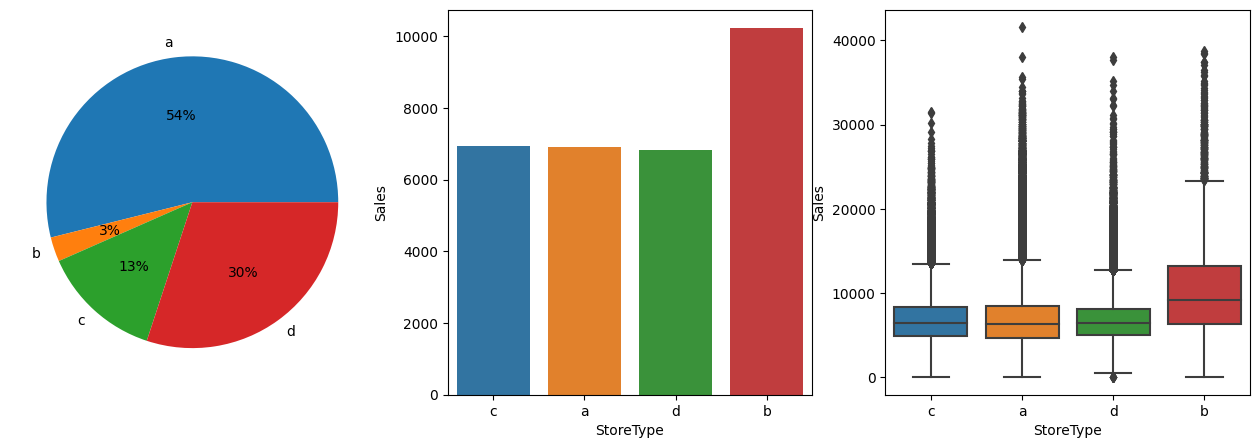

In [214]:
ab = df.groupby(['StoreType'],as_index =False)['Sales'].sum()
fig, axes = plt.subplots(1,3, figsize=(16,5))
axes[0].pie(ab['Sales'],labels=ab['StoreType'],autopct = '%.0f%%')
sns.barplot(ax =axes[1] ,x="StoreType", y="Sales",data= df,errorbar = None)
sns.boxplot(ax =axes[2] ,x = 'StoreType', y = 'Sales', data = df)

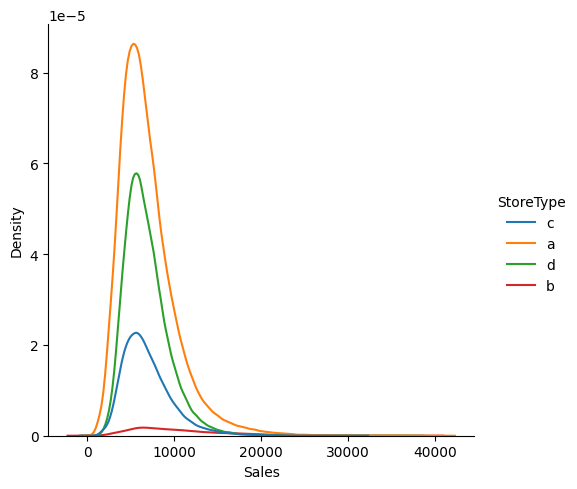

In [215]:
sns.displot(data=df, x="Sales", hue="StoreType",kind ='kde')

In [216]:
(df.loc[df['StoreType'] =='b','StoreType'].count()/df['StoreType'].count())*100

1.843101308397048

Despite only 1.84% of Store Type, store type b exhibits the highest average sales and customer numbers, indicating a stronger preference for this store type among customers.

In [217]:
stores = df.groupby(['StoreType'],as_index =False)['Sales'].sum()

<Axes: xlabel='Assortment', ylabel='Sales'>

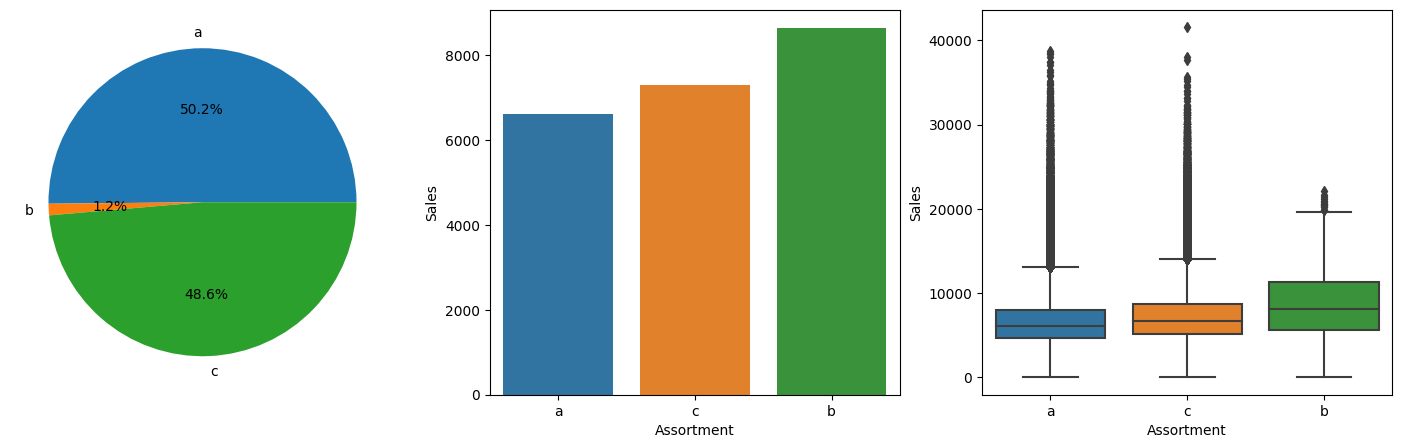

In [218]:
ab = df.groupby(['Assortment'],as_index =False)['Sales'].sum()
fig, axes = plt.subplots(1,3, figsize=(18,5))
axes[0].pie(ab['Sales'],labels=ab['Assortment'],autopct = '%.1f%%')
sns.barplot(ax =axes[1] ,x="Assortment", y="Sales",data= df,errorbar = None)
sns.boxplot(ax =axes[2] ,x = 'Assortment', y = 'Sales', data = df)

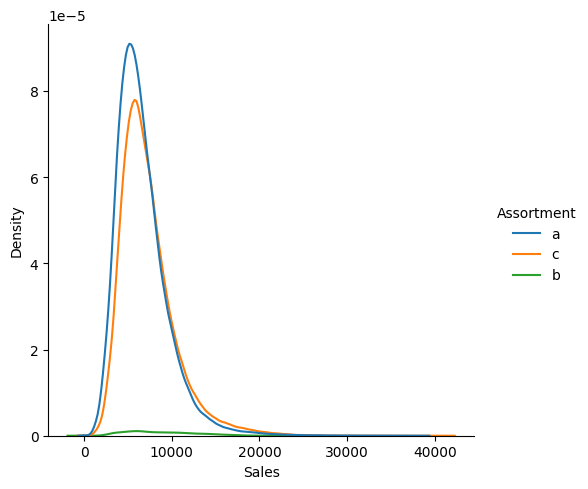

In [219]:
# Dependent variable 'Price'
sns.displot(data=df, x="Sales", hue="Assortment",kind ='kde')

In [220]:
(df.loc[df['Assortment'] =='b','Assortment'].count()/df['Assortment'].count())*100

0.9725340836957242

Despite only 0.97 % of the Assortment,Assortment b stands out with the highest average sales and customer counts, suggesting a high demand for this assortment. Now, let's examine the sales figures for each assortment across different store types.

Text(0.5, 1.0, 'Number of Sales for each Assortment per Store Type')

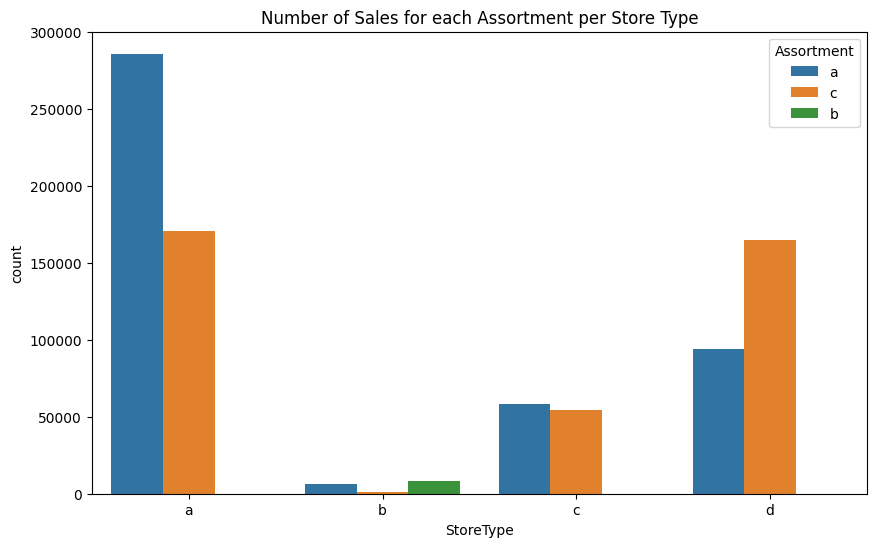

In [221]:
plt.figure(figsize=(10, 6))
sns.countplot(x='StoreType', hue='Assortment', order=sorted(df['StoreType'].unique().tolist()), data=df, palette=sns.color_palette(n_colors=3))
plt.title("Number of Sales for each Assortment per Store Type")

Exclusively, store type b offers assortment b, and it outperforms assortment a in terms of sales.

Next, let's investigate how various continuous features, such as month, year, week, etc., influence sales and customer metrics.


<Axes: xlabel='Month', ylabel='Sales'>

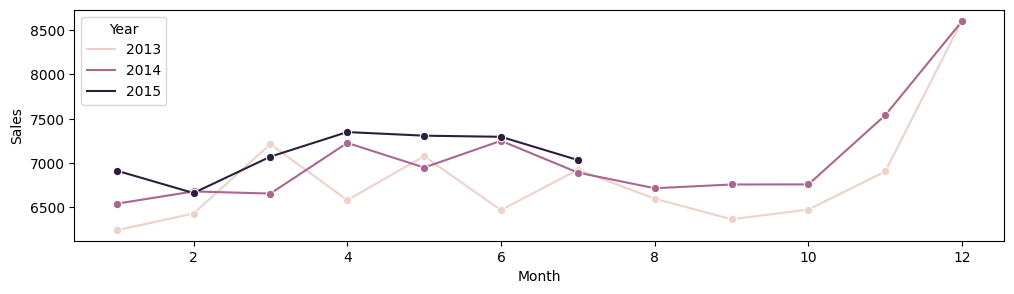

In [222]:
# line graph of monthly sales over years
plt.figure(figsize=(12,3))
sns.lineplot(x="Month" ,y = "Sales" , data=df,hue ='Year',errorbar=None,marker='o',color ='deepskyblue')

<Axes: xlabel='Month', ylabel='Customers'>

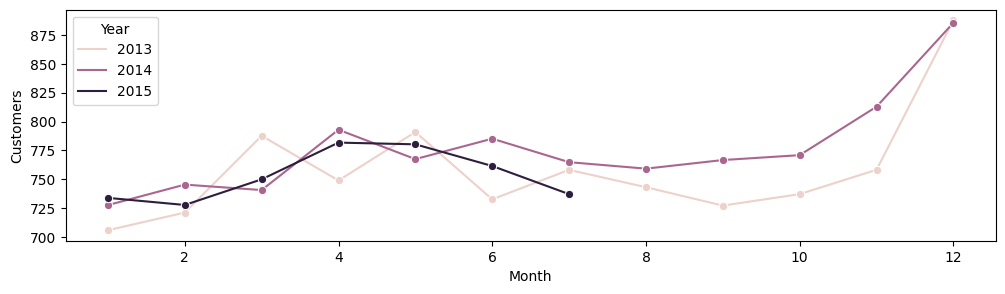

In [223]:
# line graph of monthly customers over years
plt.figure(figsize=(12,3))
sns.lineplot(x="Month" ,y = "Customers" , data=df,hue ='Year',errorbar=None,marker='o',color ='deepskyblue')

<Axes: xlabel='WeekOfYear', ylabel='Sales'>

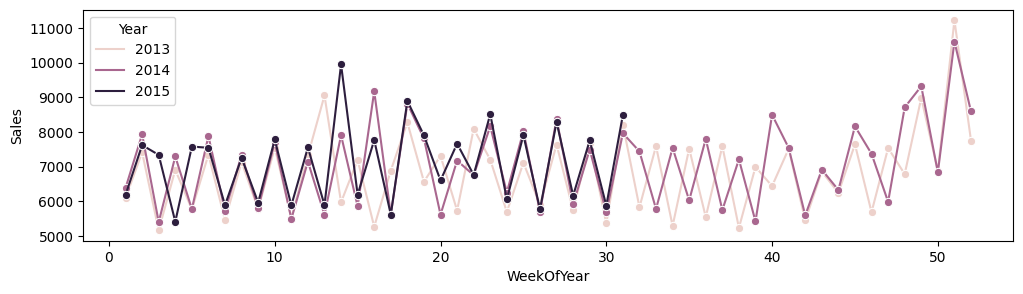

In [224]:
# line graph of weekly sales over years
plt.figure(figsize=(12,3))
sns.lineplot(x="WeekOfYear" ,y = "Sales" , data=df,hue ='Year',errorbar=None,marker='o',color ='deepskyblue')

<Axes: xlabel='WeekOfYear', ylabel='Customers'>

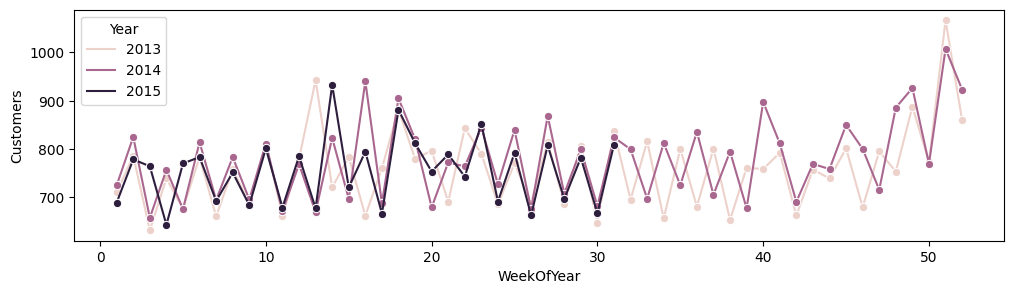

In [225]:
# line graph of weekly customers over years
plt.figure(figsize=(12,3))
sns.lineplot(x="WeekOfYear" ,y = "Customers" , data=df,hue ='Year',errorbar=None,marker='o',color ='deepskyblue')

<Axes: xlabel='Sales'>

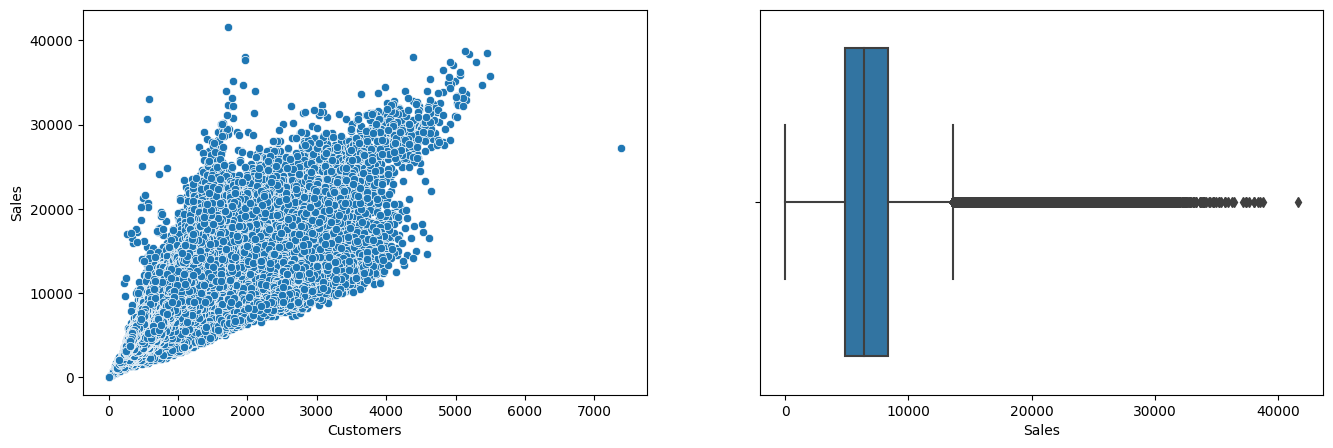

In [226]:
fig, axes = plt.subplots(1,2, figsize=(16,5))
sns.scatterplot(ax =axes[0],x= 'Customers',y='Sales', data=df)
sns.boxplot(ax =axes[1] ,x = 'Sales', data = df)

We can see Sales and Customers have high positive Correlation from the scatter plot.

Lets check weather where sales is 0 customer is also 0.

In [227]:
print('Unique Values of Customers where Sales is 0:' ,df.loc[df['Sales'] == 0,'Customers'].unique())
print('Count of Unique Values of Customers where Sales is 0:' ,df.loc[df['Sales'] == 0,'Customers'].count())

Unique Values of Customers where Sales is 0: [0 5 3]
Count of Unique Values of Customers where Sales is 0: 54


There are rows where sales is 0 but customers are not,this is not possible.

There are only 54 rows where sales is 0,so we will drop Sales rows where sales is equal to 0.

In [228]:
df.drop(df[df['Sales'] == 0].index,inplace =True)


<Axes: xlabel='CompetitionDistance'>

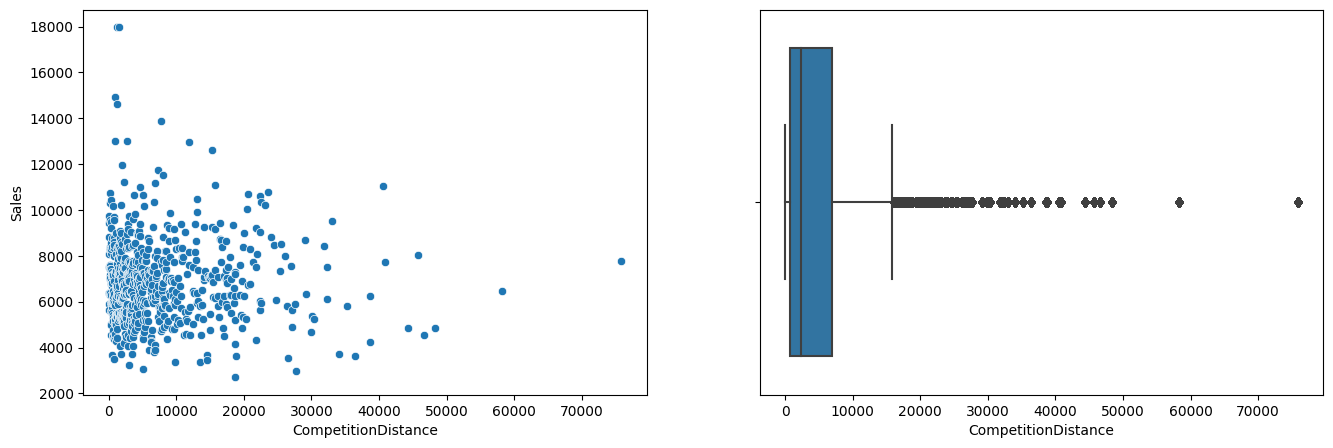

In [229]:
fig, axes = plt.subplots(1,2, figsize=(16,5))
sns.scatterplot(ax =axes[0],x= 'CompetitionDistance',y='Sales', data=df.groupby(['CompetitionDistance'],as_index =False)['Sales'].mean())
sns.boxplot(ax =axes[1] ,x = 'CompetitionDistance', data = df)

In cases where there is less competition distance, it appears that sales values tend to be higher. This might be attributed to the possibility that in areas with higher demand, multiple stores are situated.

There are very few stores where competition distance is higher than 40000 meters.

In [230]:
numerical_feature = df.describe().columns
numerical_feature

Index(['CompetitionDistance', 'Promo2', 'DayOfWeek', 'Sales', 'Customers',
       'Promo', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear'],
      dtype='object')

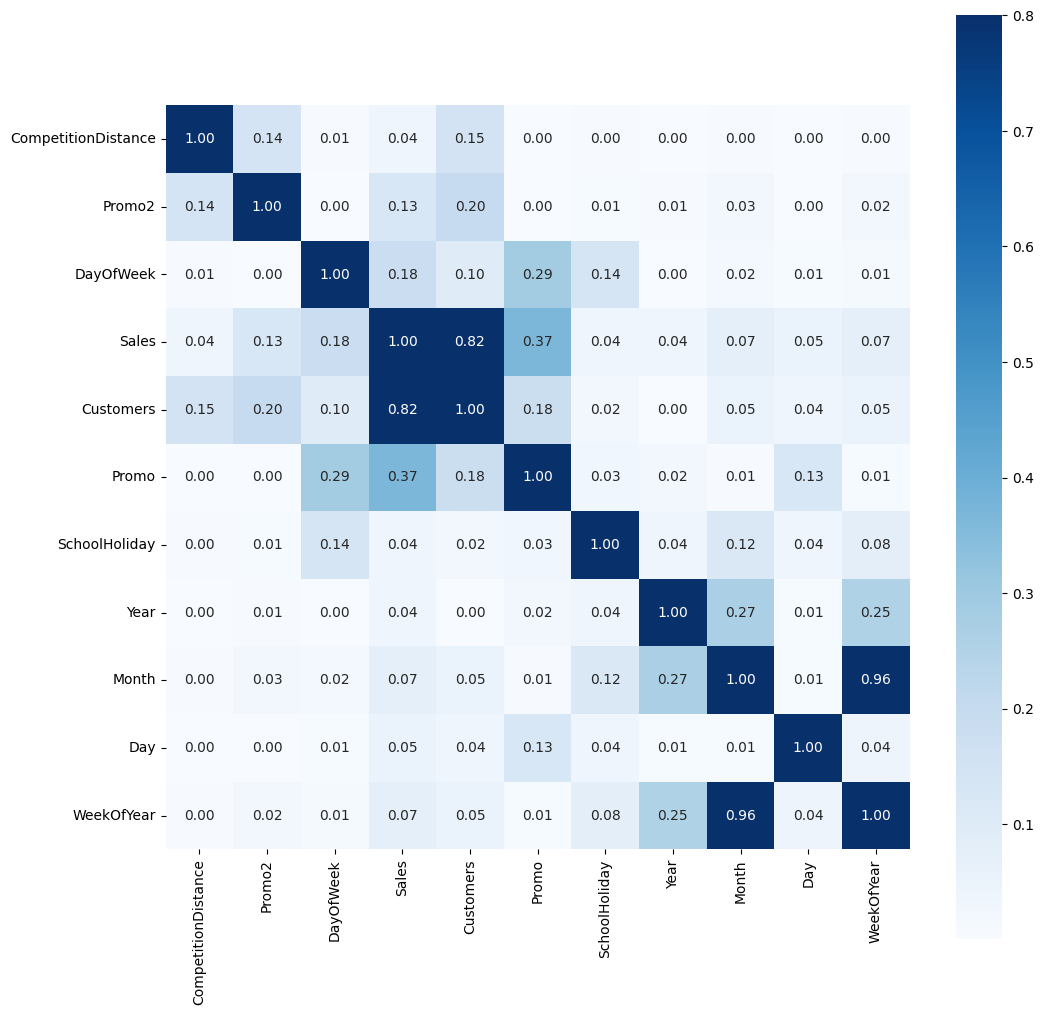

In [231]:
# generate a correlation matrix using all features in the dataframe
corr_mat = df.corr().abs()

# plot heatmap using correlation matrix
fig, axes = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_mat, annot = True, fmt='.2f', annot_kws={'size': 10},  vmax=.8, square=True, cmap='Blues');

Month has 0.96 correlation with week of year,this is beacuse weeks of year is like subset of months of year.

So,we will drop the Month column as week of year will represent the Sales more accurately.

In [232]:
#dropping Month Column
df.drop('Month',axis =1,inplace = True )

## Handling Multicollinearity
Lets find out the VIF of all numerical features except 'Sales' in order to remove highly correlated features. Features having VIF greater than 10 should be eliminated.

In [233]:
#Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [234]:
#Calculating Multicollinearity of independent variables
calc_vif(df[[i for i in df.describe().columns if i not in ['Sales',]]])

,variables,VIF
0,CompetitionDistance,1.572292
1,Promo2,2.151630
2,DayOfWeek,5.767373
3,Customers,5.188466
4,Promo,2.061180
5,SchoolHoliday,1.274325
6,Year,21.534345
7,Day,4.415568
8,WeekOfYear,3.740975


Multicollinearity of greater 10 than is not considered good, in the dataset only year has Multicollinearity of 21.

So,we will drop the year column

In [235]:
#dropping the Year column
df.drop('Year',axis = 1, inplace =True)

In [236]:
#Calculating Multicollinearity of independent variables
calc_vif(df[[i for i in df.describe().columns if i not in ['Sales',]]])

,variables,VIF
0,CompetitionDistance,1.458452
1,Promo2,1.879426
2,DayOfWeek,3.891415
3,Customers,3.939596
4,Promo,1.874417
5,SchoolHoliday,1.253272
6,Day,3.623503
7,WeekOfYear,3.382762


## **Features Distribution**

Lets check out the distribution of all the features.

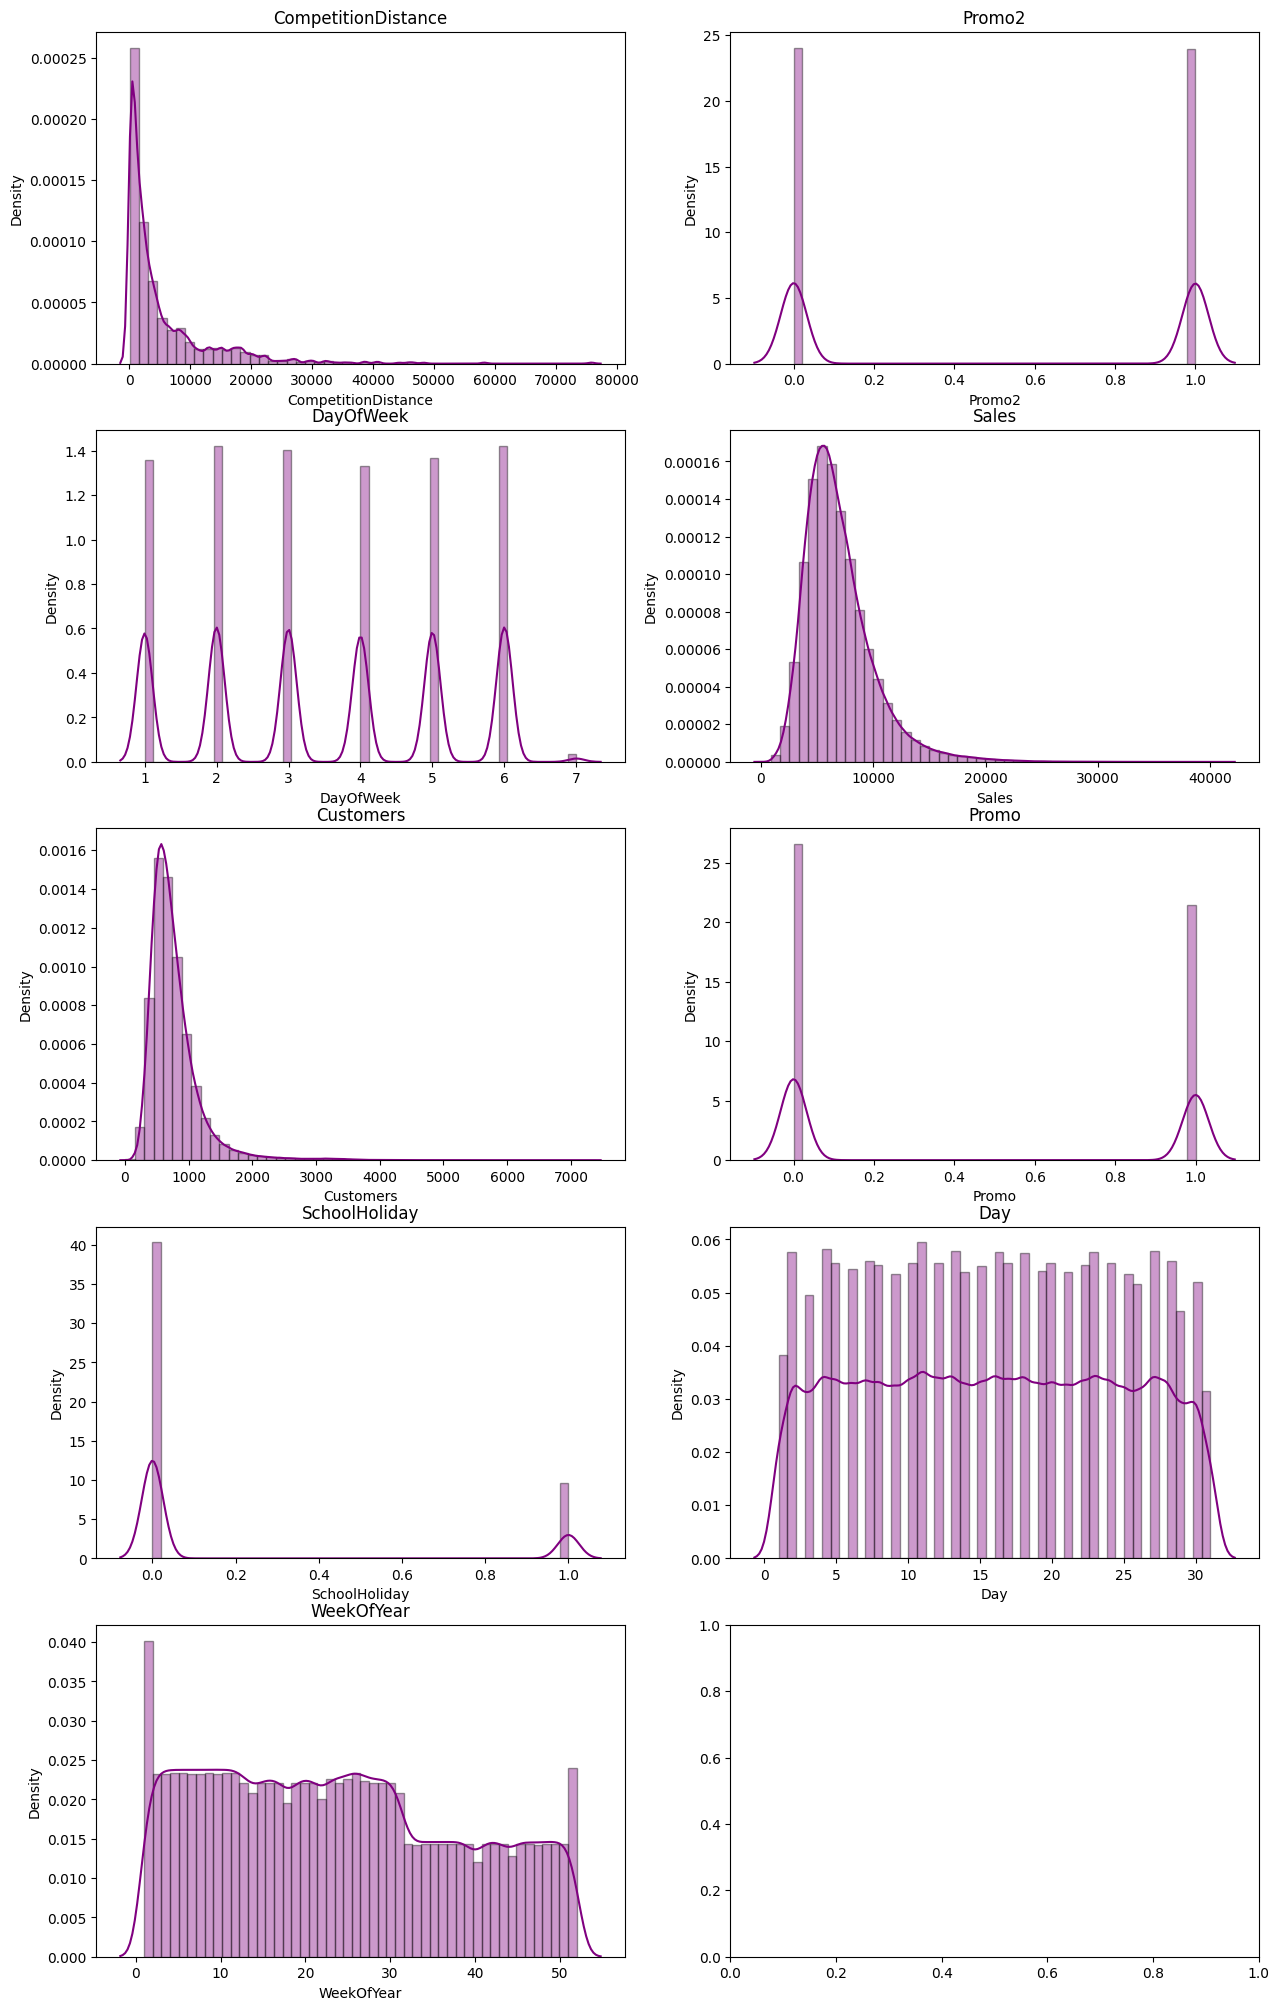

In [237]:
fig, axes = plt.subplots(nrows = 5, ncols = 2)
axes = axes.flatten()
fig.set_size_inches(15, 25)

for ax, col in zip(axes,df.describe().columns):
  sns.distplot(df[col], ax = ax, color='purple',hist_kws={"edgecolor": 'black'})
  ax.set_title(col)




Distribution of sales, customer, competition distance are positively skewed.</br>
Lets check the variation in sales with the numerical features.




In [238]:
numeric_features = ['Customers','CompetitionDistance']

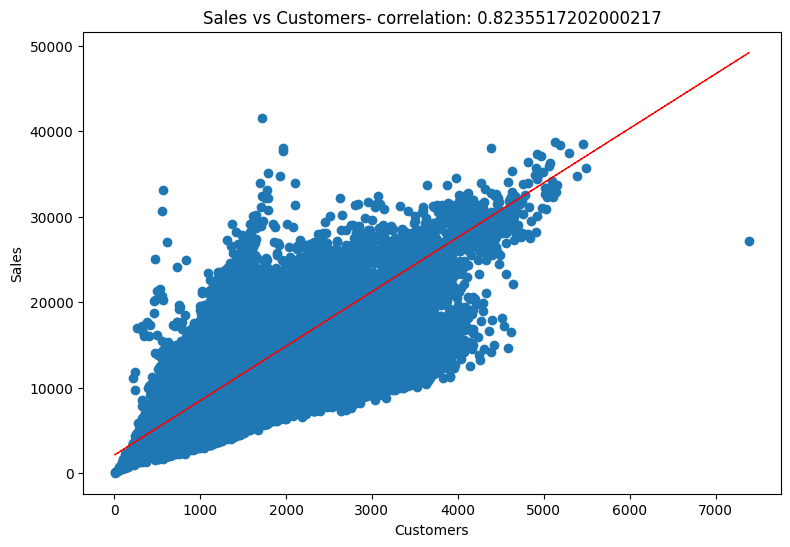

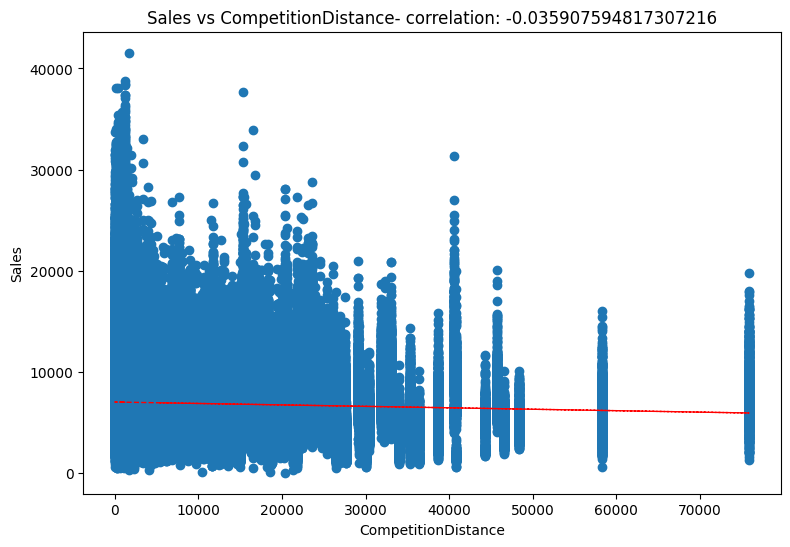

In [239]:
for col in numeric_features[:]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    label = df['Sales']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Sales')
    ax.set_title('Sales vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(df[col], df['Sales'], 1)
    y_hat = np.poly1d(z)(df[col])

    plt.plot(df[col], y_hat, "r--", lw=1)

plt.show()

The correlation between sales and customers appears to be nearly linear, indicating</br> that as the number of customers increases, sales tend to increase as well.

Sales exhibit a very slight decline with an increase in competition distance.



## **Handling Outliers**

In [240]:
def outlier_boundaries(dataframe, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    return fence_high,fence_low
def get_outlier_count_and_percentage(dataframe, column):
  upper_outlier_bound, lower_outlier_bound = outlier_boundaries(dataframe, column)
  count = 0
  for value in dataframe[column]:
    if value >  upper_outlier_bound or value < lower_outlier_bound:
      count += 1
  percentage = round(count/dataframe.shape[0]*100, 2)

  return (count, percentage)

Checking Outliers of sales

Outliers in Sales : 30769 (3.64%)


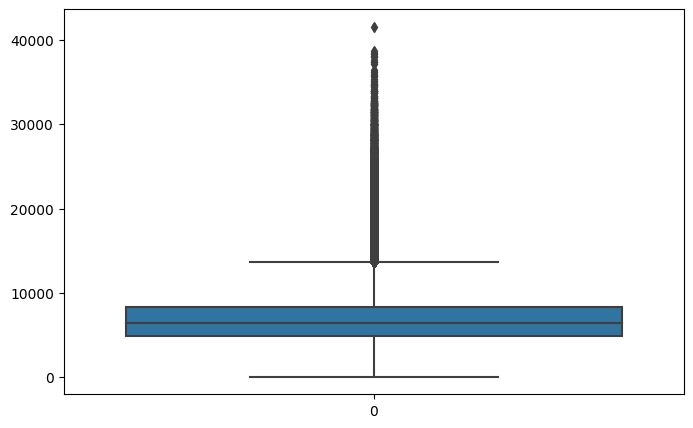

In [241]:
sns.boxplot(df['Sales'])
count, perc = get_outlier_count_and_percentage(df, 'Sales')
print(f"Outliers in Sales : {count} ({perc}%)")

In [242]:
# count and percentage of data of different values
for limit in (20000,23000,26000):
  count = df[df['Sales'] > limit].shape[0]
  perc = round(count/df.shape[0]*100, 2)
  print(f"Count & percentage of data above {limit} : {count} ({perc}%)")

Count & percentage of data above 20000 : 4099 (0.49%)
Count & percentage of data above 23000 : 1446 (0.17%)
Count & percentage of data above 26000 : 573 (0.07%)


Sales has 3.64 %  outliers and all outliers are above upper limit.</br>
Above 23000 there is 0.17% outliers,so we will remove these outliers.</br>
Eliminating all outliers may cause overfitting so we will remove only extreme outliers

In [243]:
#removing Sales values greater than 45000
df.drop(df[df['Sales'] >= 23000].index,inplace =True)

Checking Outliers of Competition Distance

Outliers in competition distance : 83010 (9.85%)


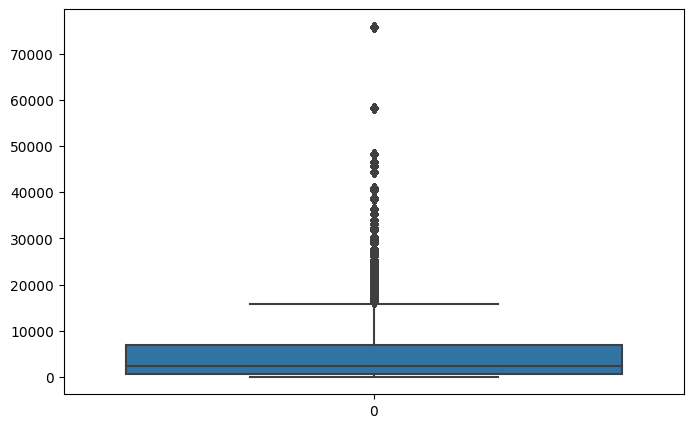

In [244]:
sns.boxplot(df['CompetitionDistance'])
count, perc = get_outlier_count_and_percentage(df, 'CompetitionDistance')
print(f"Outliers in competition distance : {count} ({perc}%)")

In [245]:
# count and percentage of data of CompetitionDistance values
for limit in (30000, 40000,45000):
  count = df[df['CompetitionDistance'] > limit].shape[0]
  perc = round(count/df.shape[0]*100, 2)
  print(f"Count & percentage of data above {limit} : {count} ({perc}%)")

Count & percentage of data above 30000 : 15442 (1.83%)
Count & percentage of data above 40000 : 6555 (0.78%)
Count & percentage of data above 45000 : 4120 (0.49%)


Outliers above 45000 are just 0.49 % of the dataset so we will remove these outliers.

In [246]:
#removing competition distance values greater than 45000
df.drop(df[df['CompetitionDistance'] >= 45000].index,inplace =True)

Outliers in Customers : 39463 (4.7%)


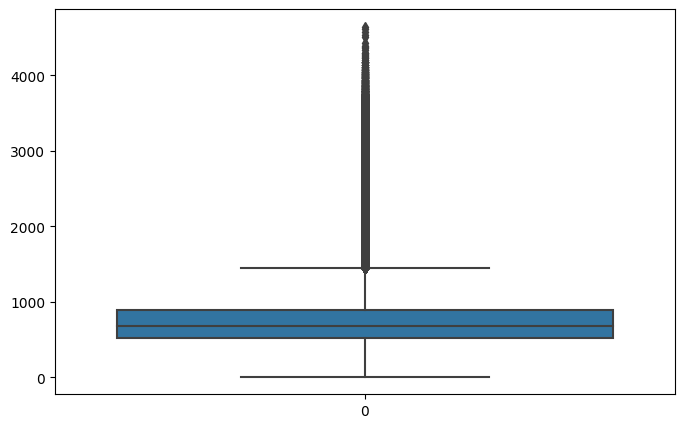

In [247]:
sns.boxplot(df['Customers'])
count, perc = get_outlier_count_and_percentage(df, 'Customers')
print(f"Outliers in Customers : {count} ({perc}%)")

In [248]:
# count and percentage of data of Customers values
for limit in [(4,4000),(9,3500),(9,2800)]:
  count = df[(df['Customers'] > limit[1]) | (df['Customers'] < limit[0])].shape[0]
  perc = round(count/df.shape[0]*100, 2)
  print(f"Count & percentage of data above {limit[1]} & below {limit[0]}: {count} ({perc}%)")

Count & percentage of data above 4000 & below 4: 71 (0.01%)
Count & percentage of data above 3500 & below 9: 746 (0.09%)
Count & percentage of data above 2800 & below 9: 4453 (0.53%)


Outliers above 3500 is just 0.09% of the dataset,so we will remove these outliers

In [249]:
# removing competition Customers greater than 45000
df.drop(df[(df['Customers'] > 3500) | (df['Customers'] < 9)].index,inplace =True)

## **Checking Outliers of Categoricals Features**

We can only check outliers of categoricals features by separate categories and check it with respect to sales.

In [250]:
categories_features = ['Assortment','StoreType']

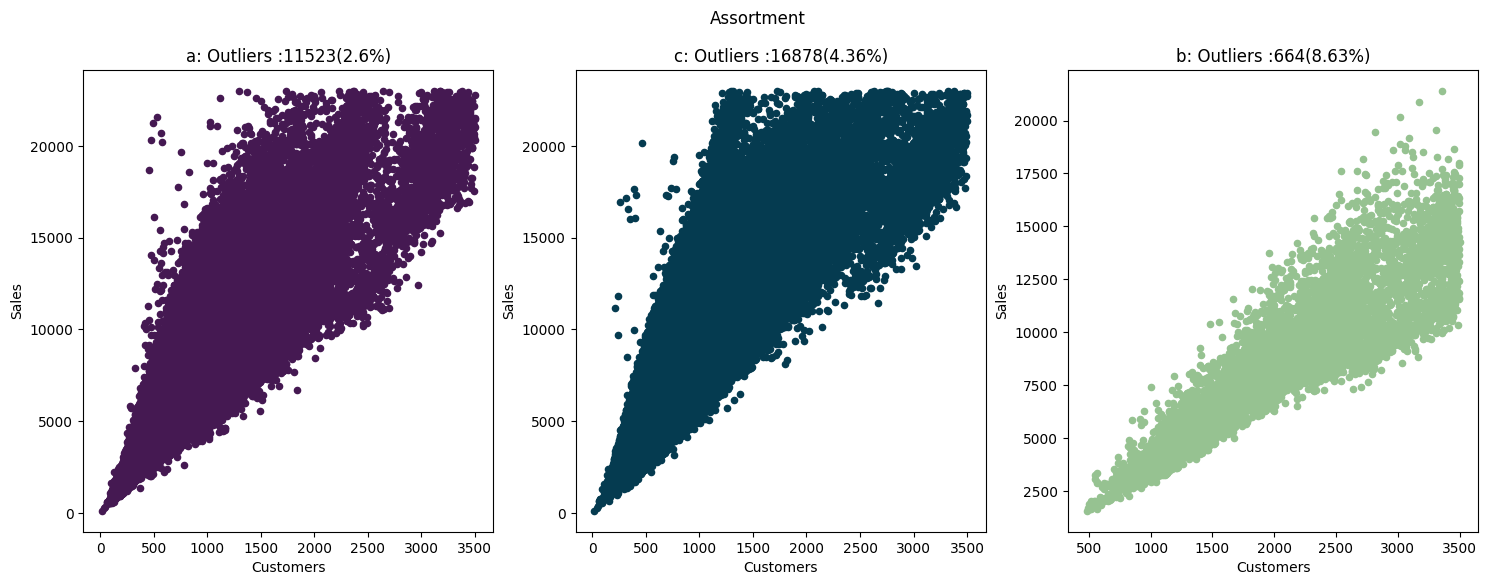

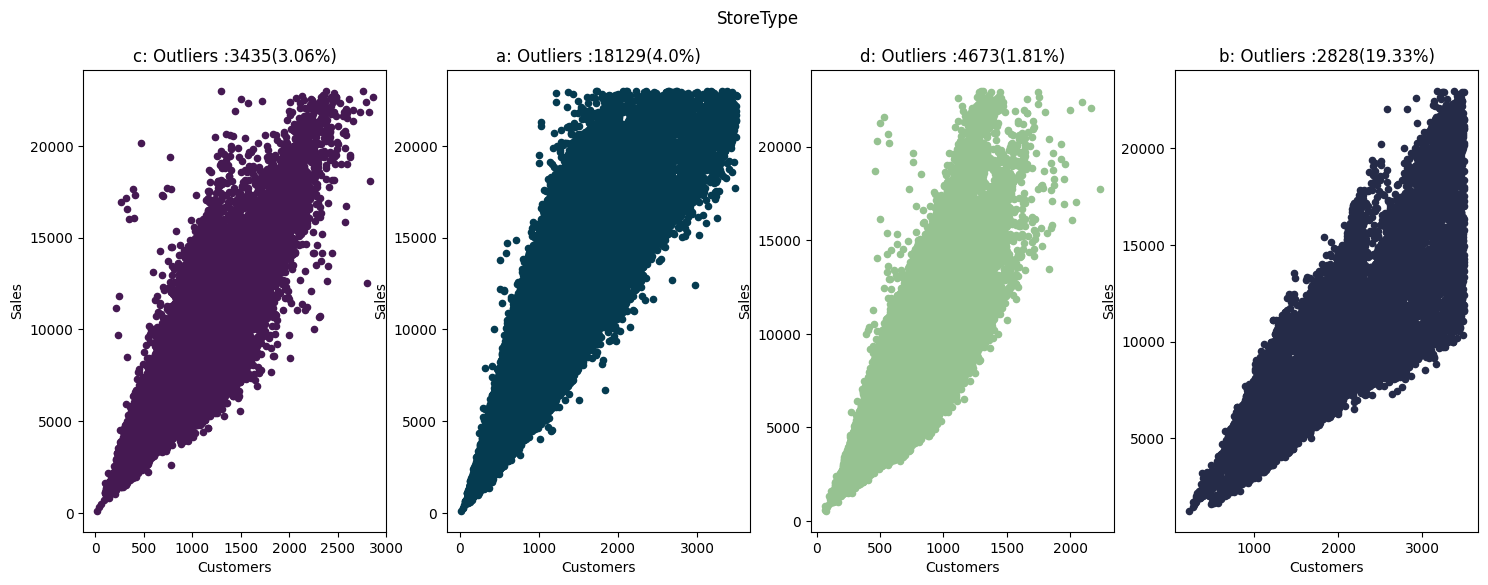

In [251]:
for col in categories_features:
  fig, axes = plt.subplots(1,len(df[col].unique()), figsize=(18,6))
  plt.suptitle(col)
  color_code = ['#451952','#053B50','#96C291','#252B48']
  for i,cate in enumerate(df[col].unique()):
     az = df[df[col] == cate]
     count, perc = get_outlier_count_and_percentage(az,'Sales')
     az.plot.scatter(ax = axes[i],x= 'Customers',y='Sales',c=color_code[i],title = f'{cate}: Outliers :{count}({perc}%)')


We will consider outliers below 5%  as tolerate limit,as we cannot remove all the outliers.</br> From the above scatter plot there are 2 category which have greter 5% outliers.</br>
<ol>
<li>StoreType(category:b) = 19.33%</li>
<li>Assortmet(Category:b) = 8.63%</li>
</ol>

So,we will try to remove these outliers




Checking outliers range of Store Type(category : b)

Text(0.5, 1.0, 'StoreType(Category:b)')

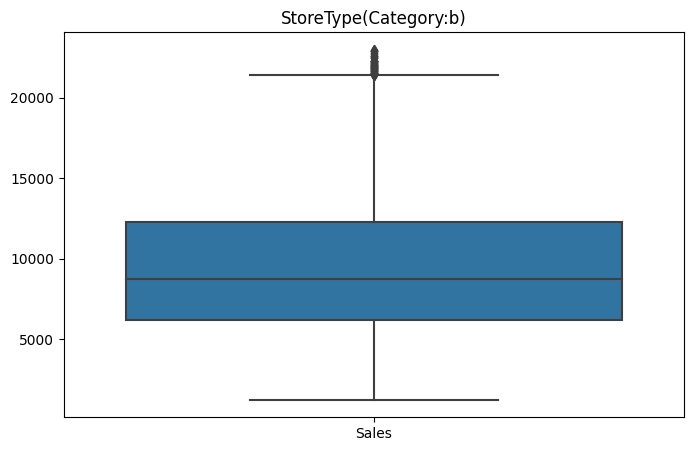

In [252]:
#cheking the boxplot of StoreType of category b
sns.boxplot(df.loc[df['StoreType'] == 'b',['Sales']])
plt.title('StoreType(Category:b)')

From the above box plot most of the outliers is above 21000  and outliers count is 2828(19.33%).</br> So we will try to remove extreme outliers.

In [253]:
#dropping StoreType of category b where sales is greater than 21000.
df.drop(df.loc[(df['StoreType'] == 'b') & (df['Sales'] >= 22000)].index,inplace =True)

Text(0.5, 1.0, 'StoreType(Category:b)')

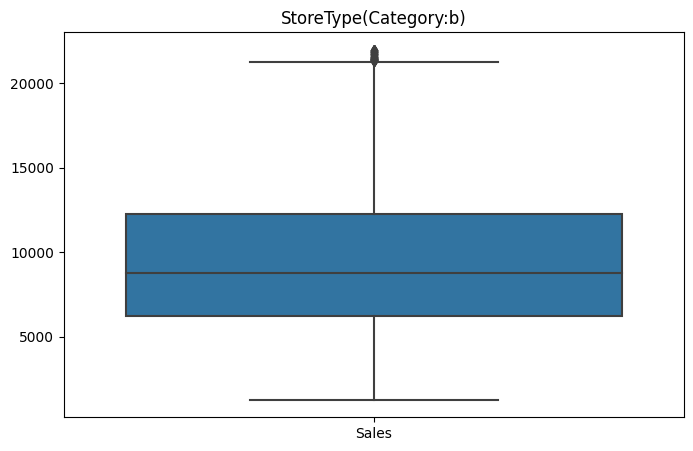

In [254]:
#cheking the boxplot of StoreType of category b
sns.boxplot(df.loc[df['StoreType'] == 'b',['Sales']])
plt.title('StoreType(Category:b)')

There is no outliers left in the StoreType of Category.</br>
Now,lets check the outliers range of Assortment Type of category b


Text(0.5, 1.0, 'Assortment(Category:b)')

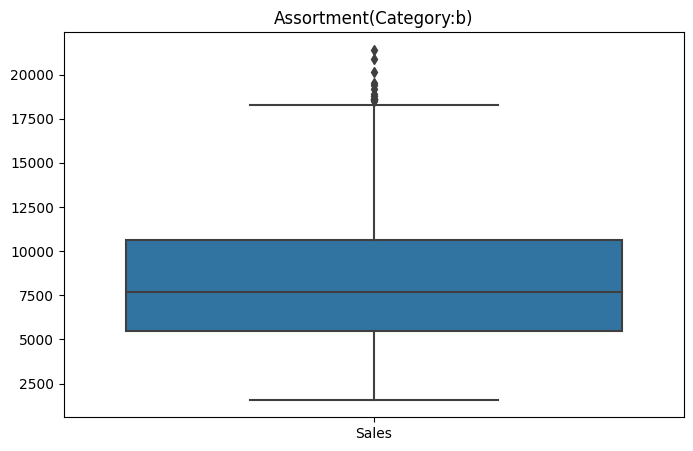

In [255]:
#cheking the boxplot of Assortment of category b
sns.boxplot(df.loc[df['Assortment'] == 'b',['Sales']])
plt.title('Assortment(Category:b)')

From the box plot we can see Assortment of category b has upper control limit around 18000.</br>
We will remove extreme outliers whose  sales are greater than 19000.

In [256]:
df.drop(df.loc[(df['Assortment'] == 'b') & (df['Sales'] >= 19000)].index,inplace =True)

Text(0.5, 1.0, 'Assortment(Category:b)')

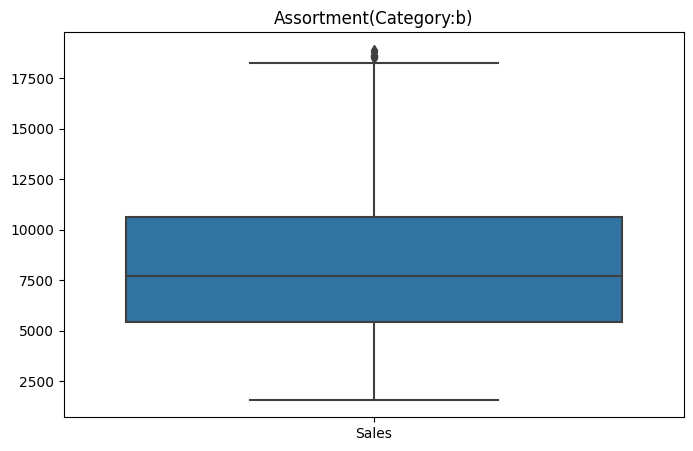

In [257]:
sns.boxplot(df.loc[df['Assortment'] == 'b',['Sales']])
plt.title('Assortment(Category:b)')

# **Feature Transformation**

From the distribution feature section we have seen that distibution of sales,customers,competition distance are positively skewed so we will apply feature transformation on them.We also know that these features does not contain 0 values,after data cleaning.</br>

So we will apply log transform to these features.

<Axes: xlabel='Sales', ylabel='Density'>

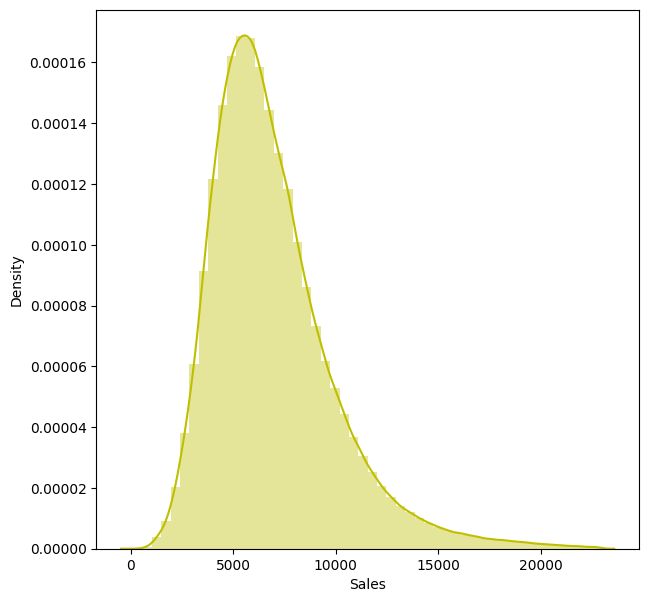

In [258]:
plt.figure(figsize=(7,7))
sns.distplot(df['Sales'],color="y")

<Axes: xlabel='Sales', ylabel='Density'>

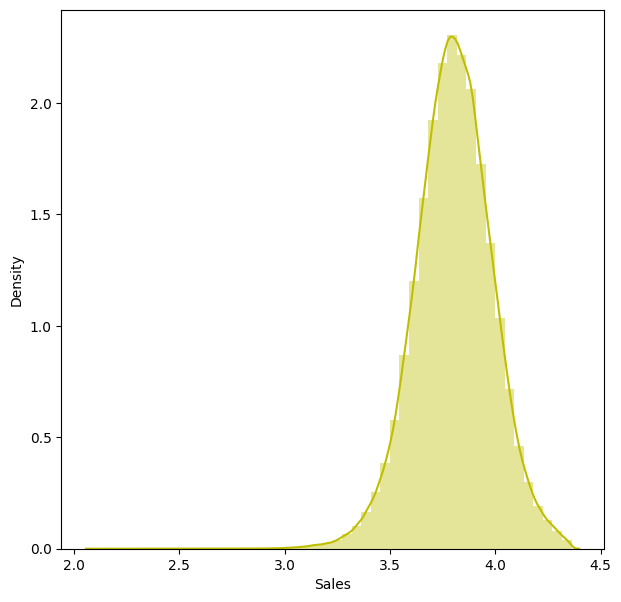

In [259]:
# square root transformation of sales, customers, competition open number of months and promo 2 number of weeks
df['Sales'] = np.log10(df['Sales'])
plt.figure(figsize=(7,7))
sns.distplot(df['Sales'],color="y")

<Axes: xlabel='Customers', ylabel='Density'>

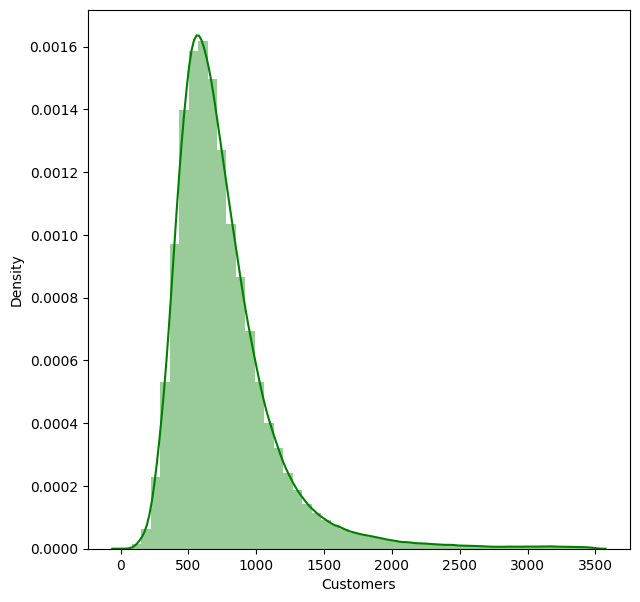

In [260]:
plt.figure(figsize=(7,7))
sns.distplot(df['Customers'],color="g")

<Axes: xlabel='Customers', ylabel='Density'>

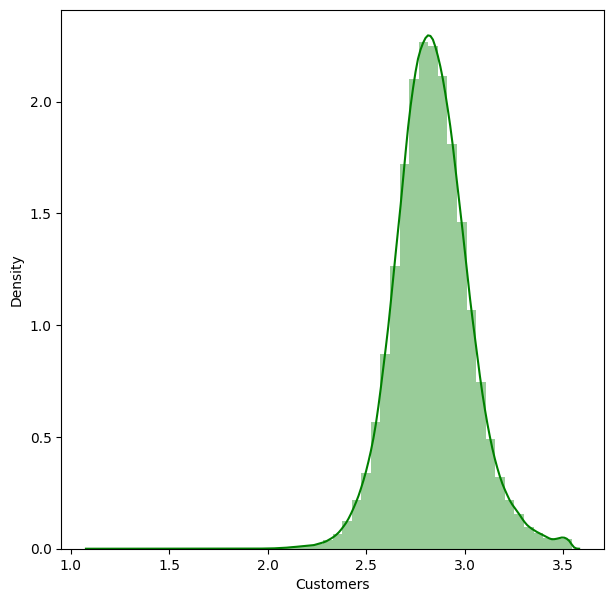

In [261]:
# square root transformation of sales, customers, competition open number of months and promo 2 number of weeks
df['Customers'] = np.log10(df['Customers'])
plt.figure(figsize=(7,7))
sns.distplot(df['Customers'],color="g")

<Axes: xlabel='CompetitionDistance', ylabel='Density'>

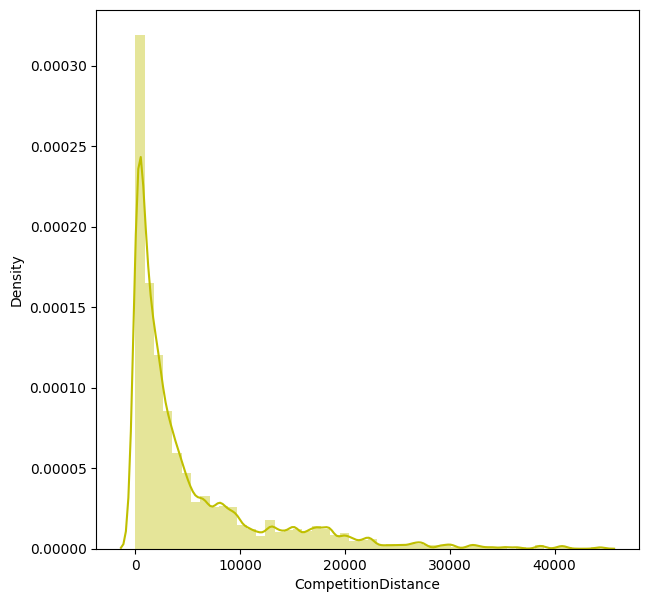

In [262]:
plt.figure(figsize=(7,7))
sns.distplot(df['CompetitionDistance'],color="y")

<Axes: xlabel='CompetitionDistance', ylabel='Density'>

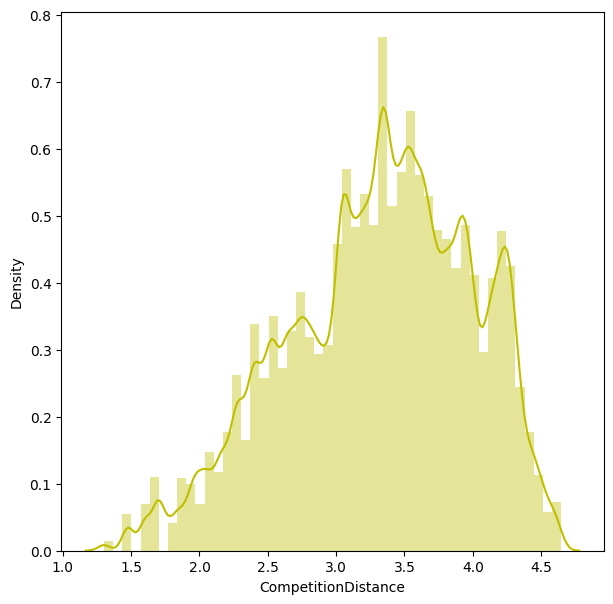

In [263]:
# square root transformation of sales, customers, competition open number of months and promo 2 number of weeks
df['CompetitionDistance'] = np.log10(df['CompetitionDistance'])
plt.figure(figsize=(7,7))
sns.distplot(df['CompetitionDistance'],color="y")

Customers,Sales transfomation are nearly normal and skewness are mostly removed.</br>
CompetitionDistance skewness are reomved but transformation is distorted normal distribution.

# **Categorical Feature Encoding**


In [264]:
#creating datframe copy
df1 = df.copy()

In [265]:
# One hot encoding
df1 = pd.get_dummies(df, columns=["StoreType","Assortment"], prefix=["Store","Assort"])

In [266]:
#Final features
feat = ['CompetitionDistance','Promo2','DayOfWeek','Customers','Promo','SchoolHoliday','Day','WeekOfYear','Store_a','Store_b','Store_c','Store_d','Assort_a','Assort_b','Assort_c']

# **Modelling**
## **Train-Test Split**
First, we will separate input features and target feature.

In [267]:
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [268]:
# independant features (input)
X = df1[feat].apply(zscore)

# dependant feature (target)
y = df1['Sales']

 splitting them into training and test data with 20% test data

In [270]:
dtypes = np.dtype(
    [
        ('Regression_Model', str),
        ('Train_MSE', float),
        ('Train_RMSE',float),
        ('Train_R2', float),
        ('Train_Adjusted_R2',float),
        ('Test_MSE',float),
        ('Test_RMSE',float),
        ('Test_R2', float),
        ('Test_Adjusted_R2',float),
    ]
)
model_accuracy = pd.DataFrame(np.empty(0, dtype=dtypes))

In [269]:
# split the datasets to training and test data
X_train, X_test, y_train, y_test = train_test_split( X,y , test_size = 0.2, random_state = 0)

# **Model Training**
## **Linear Regression**

In [271]:
# train data with linear regression
reg = LinearRegression().fit(X_train, y_train)

# predict the train  data
y_pred_train = reg.predict(X_train)
r2_train = r2_score(10**(y_train), 10**(y_pred_train))
MSE_train  = mean_squared_error(10**(y_train), 10**(y_pred_train))
RMSE_train = np.sqrt(MSE_train)
Train_Adjusted_R2 = 1-(1-r2_score(10**(y_train), 10**(y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))

# predict the test data
y_pred_test = reg.predict(X_test)
MSE_test  = mean_squared_error(10**(y_test), 10**(y_pred_test))
RMSE_test = np.sqrt(MSE_test)
r2_test = r2_score(10**(y_test), 10**(y_pred_test))
Test_Adjusted_R2 = 1-(1-r2_score(10**(y_test), 10**(y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))

# print the results of model evaluation
print('Test-train Data size')
print(f'Train Size : {X_train.shape}')
print(f'Test Size  : {X_test.shape}')
print(f'Number of Coefficient: {len(reg.coef_)}\n')

print('Training Data')
print(f'MSE         : {MSE_train}')
print(f'RMSE        : {RMSE_train}')
print(f'R2          : {r2_train}')
print(f'Adjusted R2 : {Train_Adjusted_R2}\n')

print('Testing Data')
print(f'MSE         : {MSE_test}')
print(f'RMSE        : {RMSE_test}')
print(f'R2          : {r2_test}')
print(f'Adjusted R2 : {Test_Adjusted_R2}\n')

Test-train Data size
Train Size : (670374, 15)
Test Size  : (167594, 15)
Number of Coefficient: 15

Training Data
MSE         : 1288169.9703285568
RMSE        : 1134.9757575950937
R2          : 0.855491360583981
Adjusted R2 : 0.8554881270437067

Testing Data
MSE         : 1297806.791796878
RMSE        : 1139.2132336822979
R2          : 0.8541075149674733
Adjusted R2 : 0.8540944560499812



In [272]:
model_accuracy.loc[len(model_accuracy.index)] = ['Linear_Regression',MSE_train,RMSE_train,r2_train,Train_Adjusted_R2,MSE_test,RMSE_test,r2_test,Test_Adjusted_R2]

Text(7.100597222222222, 0.5, 'Density')

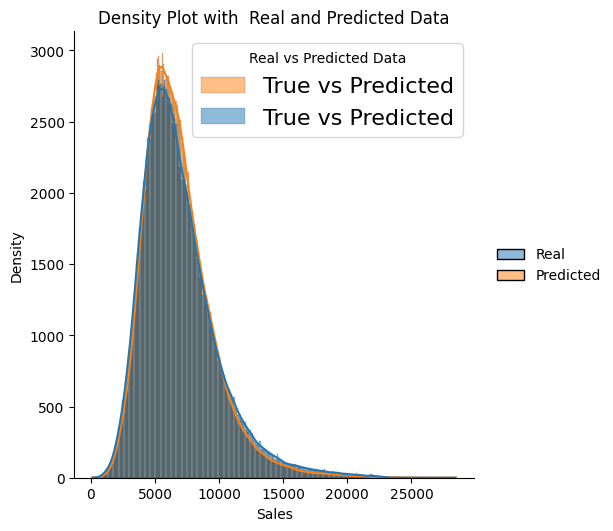

In [273]:
 # Draw the density plot
ab = {'Real':10**(np.array(y_test)),'Predicted' :10**(y_pred_test)}
sns.displot(ab,kde = True,label = "True vs Predicted")

# Plot formatting
plt.legend(prop={'size': 16}, title = 'Real vs Predicted Data')
plt.title('Density Plot with  Real and Predicted Data')
plt.xlabel('Sales')
plt.ylabel('Density')

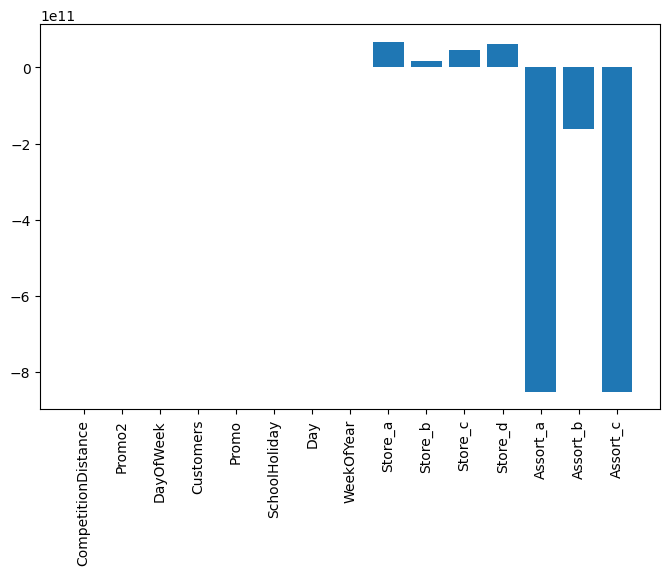

In [274]:
# linear regression feature importance
importance = reg.coef_

# plot feature importance
ax = plt.bar([x for x in range(len(importance))], importance)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], feat,rotation=90)
plt.show()

# **Lasso Regression with Hyperparameter Tuning**

In [302]:
# train data with lasso regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-5,1e-3,1e-1,1,5,10,20]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-05, 0.001, 0.1, 1, 5,
                                   10, 20]},
             scoring='neg_mean_squared_error')

In [303]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-10}

Using  {'alpha': 1e-10}  the negative mean squared error is:  -0.004470341948792855


In [305]:

# predict the train  data and  print the best parameter values and negative mean squared error
y_pred_lasso_train = lasso_regressor.predict(X_train)
MSE_train  = mean_squared_error(10**(y_train), 10**(y_pred_lasso_train))
RMSE_train = np.sqrt(MSE_train)
r2_train = r2_score(10**(y_train), 10**(y_pred_lasso_train))
Train_Adjusted_R2 = 1-(1-r2_score(10**(y_train), 10**(y_pred_lasso_train)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
#print best parameter coefficient
coefs = lasso_regressor.best_estimator_
print(f'Best Parameter Coefficients : {coefs.coef_}\n')


print('Training Data')
print(f'MSE : {MSE_train}')
print(f'RMSE : {RMSE_train}')
print(f'R2 : {r2_train}')
print(f'Adjusted R2 : {Train_Adjusted_R2}\n')

# predict the test  data and  print the best parameter values and negative mean squared error
y_pred_lasso_test = lasso_regressor.predict(X_test)
MSE_test  = mean_squared_error(10**(y_test), 10**(y_pred_lasso_test))
RMSE_test = np.sqrt(MSE_test)
r2_test = r2_score(10**(y_test),10**(y_pred_lasso_test))
Test_Adjusted_R2 = 1-(1-r2_score(10**(y_test), 10**(y_pred_lasso_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print('Testing Data')
print(f'MSE : {MSE_test}')
print(f'RMSE : {RMSE_test}')
print(f'R2 : {r2_test}')
print(f'Adjusted R2 : {Test_Adjusted_R2}\n')

Best Parameter Coefficients : [ 0.02635382  0.01580363 -0.00059142  0.17563085  0.03035295  0.00083806
  0.00038256  0.00288942 -0.02478388 -0.01847507 -0.02072856  0.01274708
 -0.00479493 -0.01860552  0.00189471]

Training Data
MSE : 1288560.7856900655
RMSE : 1135.1479135734098
R2 : 0.855447518391215
Adjusted R2 : 0.8554345794181748

Testing Data
MSE : 1298132.7584177551
RMSE : 1139.3562912529842
R2 : 0.8540708715466976
Adjusted R2 : 0.8540578093492325



In [306]:
model_accuracy.loc[len(model_accuracy.index)] = ['Lasso_Regression',MSE_train,RMSE_train,r2_train,Train_Adjusted_R2,MSE_test,RMSE_test,r2_test,Test_Adjusted_R2]

Text(7.100597222222222, 0.5, 'Density')

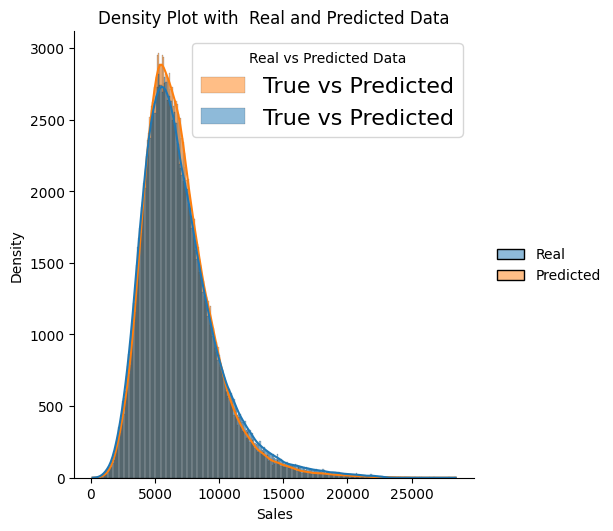

In [94]:
 # Draw the density plot
ab = {'Real':10**(np.array(y_test)),'Predicted' :10**(y_pred_lasso_test)}
sns.displot(ab,kde = True,label = "True vs Predicted")

# Plot formatting
plt.legend(prop={'size': 16}, title = 'Real vs Predicted Data')
plt.title('Density Plot with  Real and Predicted Data')
plt.xlabel('Sales')
plt.ylabel('Density')

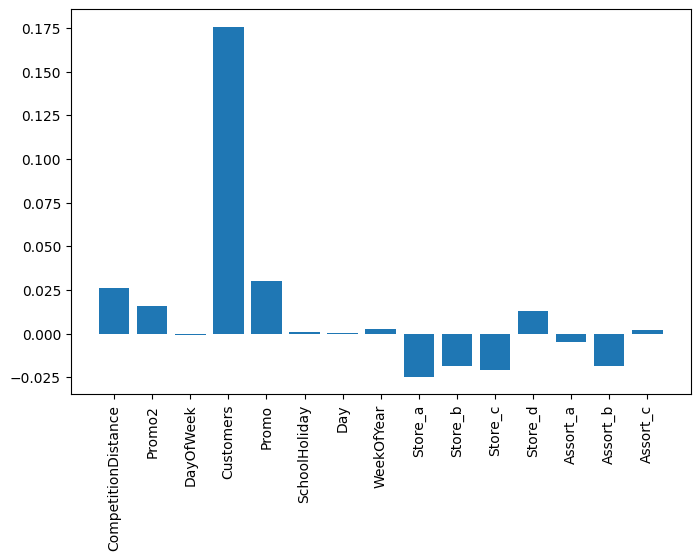

In [95]:
# linear regression feature importance
# get importance
importance = coefs.coef_
# summarize feature importance
# plot feature importance
ax = plt.bar([x for x in range(len(importance))], importance)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], feat,rotation=90)
plt.show()

# **Ridge Regression with Hyperparameter Tuning**

In [280]:
# train data with ridge regression and hyperparameter tuning
from sklearn.linear_model import Ridge
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1,5,10,20,30,40,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 1, 5, 10,
                                   20, 30, 40, 100]},
             scoring='neg_mean_squared_error')

In [281]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1}

Using  {'alpha': 1}  the negative mean squared error is:  -0.004470341948792855


In [282]:

# predict the train  data and  print the best parameter values and negative mean squared error
y_pred_ridge_train = ridge_regressor.predict(X_train)
MSE_train  = mean_squared_error(10**(y_train), 10**(y_pred_ridge_train))
RMSE_train = np.sqrt(MSE_train)
r2_train = r2_score(10**(y_train), 10**(y_pred_lasso_train))
Train_Adjusted_R2 = 1-(1-r2_score(10**(y_train), 10**(y_pred_lasso_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
#print best parameter coefficient
coefs = ridge_regressor.best_estimator_
print(f'Best parameter coefficients : {coefs.coef_}\n')

print('Training Data')
print(f'MSE : {MSE_train}')
print(f'RMSE : {RMSE_train}')
print(f'R2 : {r2_train}')
print(f'Adjusted R2 : {Train_Adjusted_R2}\n')

# predict the test  data and  print the best parameter values and negative mean squared error
y_pred_ridge_test = ridge_regressor.predict(X_test)
MSE_test  = mean_squared_error(10**(y_test), 10**(y_pred_ridge_test))
RMSE_test = np.sqrt(MSE_test)
r2_test = r2_score(10**(y_test), 10**(y_pred_lasso_test))
Test_Adjusted_R2 = 1-(1-r2_score(10**(y_test), 10**(y_pred_lasso_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print('Testing Data')
print(f'MSE : {MSE_test}')
print(f'RMSE : {RMSE_test}')
print(f'R2 : {r2_test}')
print(f'Adjusted R2 : {Test_Adjusted_R2}\n')

Best parameter coefficients : [ 0.02635369  0.01580352 -0.00059147  0.17563045  0.03035299  0.00083806
  0.00038255  0.00288943 -0.01142053 -0.01496934 -0.01159924  0.02512471
 -0.00162108 -0.01799936  0.00506468]

Training Data
MSE : 1288561.2055052638
RMSE : 1135.1480984899124
R2 : 0.855447518391215
Adjusted R2 : 0.8554442838699232

Testing Data
MSE : 1298133.124737628
RMSE : 1139.3564520103566
R2 : 0.8540708715466976
Adjusted R2 : 0.8540578093492325



In [283]:
model_accuracy.loc[len(model_accuracy.index)] = ['Ridge_Regression',MSE_train,RMSE_train,r2_train,Train_Adjusted_R2,MSE_test,RMSE_test,r2_test,Test_Adjusted_R2]

Text(7.100597222222222, 0.5, 'Density')

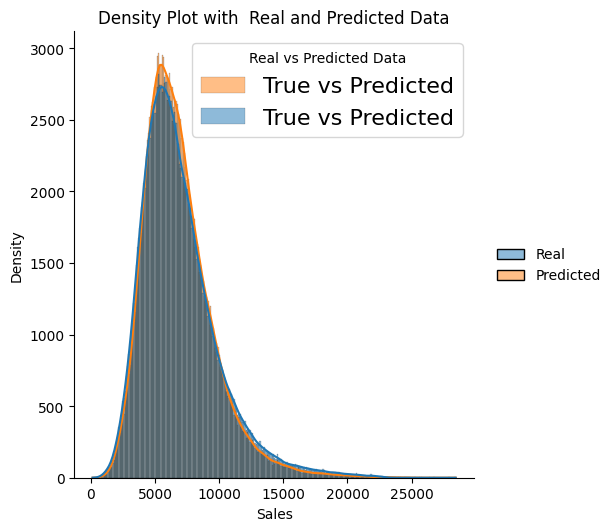

In [99]:
 # Draw the density plot
ab = {'Real':10**(np.array(y_test)),'Predicted' :10**(y_pred_ridge_test)}
sns.displot(ab,kde = True,label = "True vs Predicted")

# Plot formatting
plt.legend(prop={'size': 16}, title = 'Real vs Predicted Data')
plt.title('Density Plot with  Real and Predicted Data')
plt.xlabel('Sales')
plt.ylabel('Density')

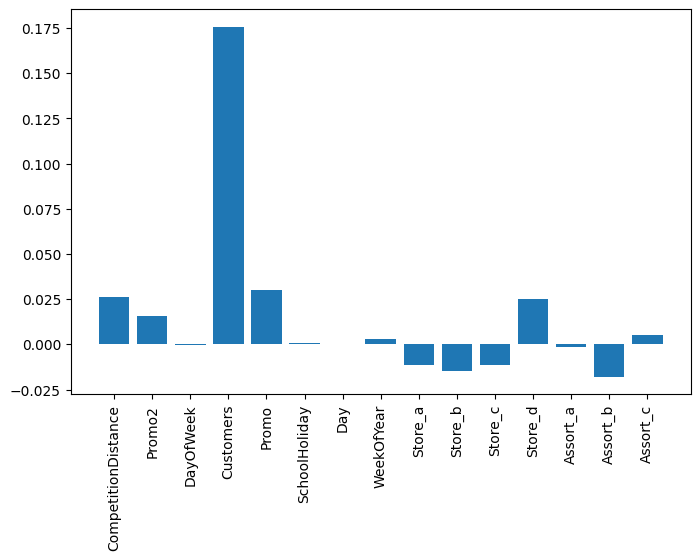

In [100]:
# linear regression feature importance
# get importance
importance = coefs.coef_

# plot feature importance
ax = plt.bar([x for x in range(len(importance))], importance)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], feat,rotation=90)
plt.show()

# **Elastic Net Regression with Hyperparameter Tuning**

In [284]:
# train data with Elastic Net regression
from sklearn.linear_model import ElasticNet
elastic = ElasticNet()
parameters = {'alpha': [1e-11,1e-10,1e-8,1e-5,1e-3,1e-1,1,5,10],'l1_ratio':[0.3,0.5,0.7,0.75,0.8,0.9]}
elastic_regressor = GridSearchCV(elastic, parameters, scoring='neg_mean_squared_error',cv=5)
elastic_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [1e-11, 1e-10, 1e-08, 1e-05, 0.001, 0.1, 1, 5,
                                   10],
                         'l1_ratio': [0.3, 0.5, 0.7, 0.75, 0.8, 0.9]},
             scoring='neg_mean_squared_error')

In [285]:
print("The best fit alpha value is found out to be :" ,elastic_regressor.best_params_)
print("\nUsing ",elastic_regressor.best_params_, " the negative mean squared error is: ", elastic_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-08, 'l1_ratio': 0.7}

Using  {'alpha': 1e-08, 'l1_ratio': 0.7}  the negative mean squared error is:  -0.00447034194873164


In [286]:
# predict the train  data and  print the best parameter values and negative mean squared error

y_pred_elastic_train = elastic_regressor.predict(X_train)
MSE_train  = mean_squared_error(10**(y_train), 10**(y_pred_elastic_train))
RMSE_train = np.sqrt(MSE_train)
r2_train = r2_score(10**(y_train), 10**(y_pred_elastic_train))
Train_Adjusted_R2 = 1-(1-r2_score(10**(y_train), 10**(y_pred_elastic_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))

#predict the bestparameter coefficient
print(f'Best parameter coefficients : {coefs.coef_}\n')
coefs = elastic_regressor.best_estimator_

print('Training Data')
print(f'MSE : {MSE_train}')
print(f'RMSE : {RMSE_train}')
print(f'R2 : {r2_train}')
print(f'Adjusted R2 : {Train_Adjusted_R2}\n')

# predict the test  data and  print the best parameter values and negative mean squared error
y_pred_elastic_test = elastic_regressor.predict(X_test)
MSE_test  = mean_squared_error(10**(y_test), 10**(y_pred_elastic_test))
RMSE_test = np.sqrt(MSE_test)
r2_test = r2_score(10**(y_test), 10**(y_pred_elastic_test))
Test_Adjusted_R2 = 1-(1-r2_score(10**(y_test), 10**(y_pred_elastic_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print('Testing Data')
print(f'MSE : {MSE_test}')
print(f'RMSE : {RMSE_test}')
print(f'R2 : {r2_test}')
print(f'Adjusted R2 : {Test_Adjusted_R2}\n')

Best parameter coefficients : [ 0.02635369  0.01580352 -0.00059147  0.17563045  0.03035299  0.00083806
  0.00038255  0.00288943 -0.01142053 -0.01496934 -0.01159924  0.02512471
 -0.00162108 -0.01799936  0.00506468]

Training Data
MSE : 1288560.8146823586
RMSE : 1135.1479263436809
R2 : 0.8554475151388206
Adjusted R2 : 0.855444280617456

Testing Data
MSE : 1298132.7840245361
RMSE : 1139.3563024903738
R2 : 0.8540708686681205
Adjusted R2 : 0.8540578064703979



In [287]:
model_accuracy.loc[len(model_accuracy.index)] = ['Elastic_Net_Regression',MSE_train,RMSE_train,r2_train,Train_Adjusted_R2,MSE_test,RMSE_test,r2_test,Test_Adjusted_R2]

Text(7.100597222222222, 0.5, 'Density')

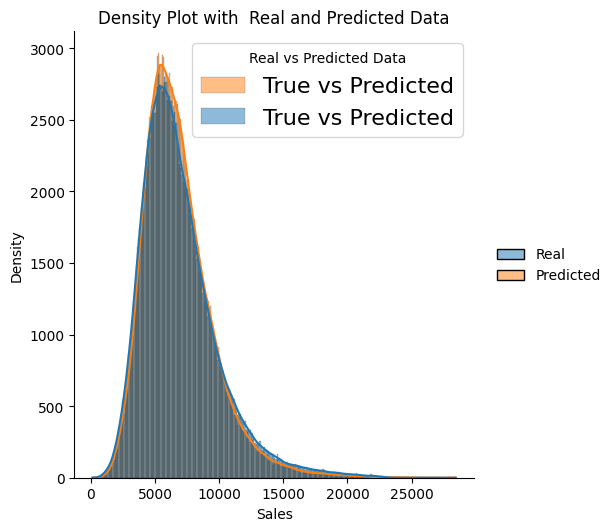

In [104]:
 # Draw the density plot
ab = {'Real':10**(np.array(y_test)),'Predicted' :10**(y_pred_elastic_test)}
sns.displot(ab,kde = True,label = "True vs Predicted")

# Plot formatting
plt.legend(prop={'size': 16}, title = 'Real vs Predicted Data')
plt.title('Density Plot with  Real and Predicted Data')
plt.xlabel('Sales')
plt.ylabel('Density')

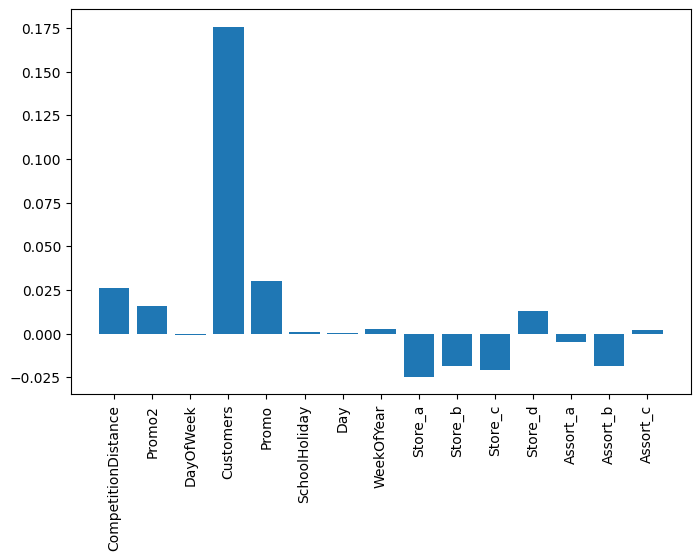

In [105]:
# linear regression feature importance
# get importance
importance = coefs.coef_

# plot feature importance
ax = plt.bar([x for x in range(len(importance))], importance)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], feat,rotation=90)
plt.show()

# **Random Forest Regression**

In [309]:
# train data with random forest regression
from sklearn.ensemble import RandomForestRegressor
rdf = RandomForestRegressor(n_estimators=15)
rdf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=15)

In [311]:
# predict the train  data and  print the best parameter values and negative mean squared error
y_pred_rdf_train = rdf.predict(X_train)
MSE_train  = mean_squared_error(10**(y_train), 10**(y_pred_rdf_train))
RMSE_train = np.sqrt(MSE_train)
r2_train = r2_score(10**(y_train), 10**(y_pred_rdf_train))
Train_Adjusted_R2 = 1-(1-r2_score(10**(y_train), 10**(y_pred_rdf_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print('Training Data')
print(f'MSE : {MSE_train}')
print(f'RMSE : {RMSE_train}')
print(f'R2 : {r2_train}')
print(f'Adjusted R2 : {Train_Adjusted_R2}\n')

# predict the test  data and  print the best parameter values and negative mean squared error
y_pred_rdf_test = rdf.predict(X_test)
MSE_test  = mean_squared_error(10**(y_test), 10**(y_pred_rdf_test))
RMSE_test = np.sqrt(MSE_test)
r2_test = r2_score(10**(y_test), 10**(y_pred_rdf_test))
Test_Adjusted_R2 = 1-(1-r2_score(10**(y_test), 10**(y_pred_rdf_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print('Testing Data')
print(f'MSE : {MSE_test}')
print(f'RMSE : {RMSE_test}')
print(f'R2 : {r2_test}')
print(f'Adjusted R2 : {Test_Adjusted_R2}\n')

Training Data
MSE : 58823.74104037651
RMSE : 242.5360613195005
R2 : 0.9934010736324361
Adjusted R2 : 0.9934009259741766

Testing Data
MSE : 337592.41906893544
RMSE : 581.0270381565176
R2 : 0.9620496692902053
Adjusted R2 : 0.9620462723349925



In [312]:
model_accuracy.loc[len(model_accuracy.index)] = ['Random_Forest_Regression',MSE_train,RMSE_train,r2_train,Train_Adjusted_R2,MSE_test,RMSE_test,r2_test,Test_Adjusted_R2]

In [313]:
model_accuracy

,Regression_Model,Train_MSE,Train_RMSE,Train_R2,Train_Adjusted_R2,Test_MSE,Test_RMSE,Test_R2,Test_Adjusted_R2
0,Linear_Regression,1.288170e+06,1134.975758,0.855491,0.855488,1.297807e+06,1139.213234,0.854108,0.854094
1,Lasso_Regression,1.288561e+06,1135.148098,0.855448,0.855444,1.298133e+06,1139.356452,0.854071,0.854058
2,Elastic_Net_Regression,1.288561e+06,1135.147926,0.855448,0.855444,1.298133e+06,1139.356302,0.854071,0.854058
3,Lasso_Regression,1.288561e+06,1135.147914,0.855448,0.855435,1.298133e+06,1139.356291,0.854071,0.854058
4,Random_Forest_Regression,1.288561e+06,1135.147914,0.855448,0.855435,1.298133e+06,1139.356291,0.854071,0.854058
5,Random_Forest_Regression,5.882374e+04,242.536061,0.993401,0.993401,3.375924e+05,581.027038,0.962050,0.962046
